In [1]:
## Overview 

In [13]:
### Import Libraries
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from joblib import dump, load
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import time
import sys
sys.path.insert(0,'../../../../../utils')
from helper_functions import *
#import helper_function custom library
from model_builder import ModelBuilder
pd.options.mode.chained_assignment = None
%matplotlib inline 

In [12]:
### Import Data and Clean Data


In [24]:
#load spectra data
df_aug = pd.read_csv("../../../../../data/refCanopies0802_0630.txt")
df_sep = pd.read_csv("../../../../../data/refCanopies0917_0630.txt")
df_oct = pd.read_csv("../../../../../data/refCanopies1016_0630.txt")

#load tree data
df_tree = pd.read_csv("../../../../../data/Export_Output_2_0630.txt")

In [25]:
#clean data
#removes non-vegatation pixels, tRef.NDVI = (tRef.x800_67 - tRef.x679_92) ./ (tRef.x800_67 + tRef.x679_92)
#removes shaded or dark pixels as well, (pixel's reflectance@800_67 <=0.15)
df_aug = data_cleaning(df_tree,df_aug)
df_sep = data_cleaning(df_tree,df_sep)
df_oct = data_cleaning(df_tree,df_oct)

In [26]:
### Merge Data and Split Data

In [27]:
#merge data
#column-wise left-join of the three datasets
#join August and September images by extracting common pixels (intersections)
df = merge_images([df_aug,df_sep,df_oct])

In [28]:
df.shape

(71868, 888)

In [ ]:
### No Dimesion Reduction

In [9]:
#groupby
#prepare data for october
df = df.groupby(['ROIID','TARGET'], as_index = False).mean()
x_test = df_nd[df_nd.columns[3:]].values
y_test = LabelEncoder().fit_transform(df_nd.TARGET)


In [18]:
labels = ['Sugar Maple', "Eastern Redbud", "Green Ash", 'Norway Spruce','Austrian Pine','Ponderosa Pine',
          'Colorado Spruce', 'Scotch Pine','White Oak','Bur Oak', 'Red Oak']
nclasses = 11
evals = []

../pixels/models\species_hyper_merged_nd.joblib


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


../pixels/models\species_hyper_merged_pc.joblib
          PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
974 -0.270121  1.372314 -0.105336  0.209816 -0.238855 -0.049062  0.166362   
975  0.335049  1.235078  0.667517  0.121751 -0.091558 -0.041380  0.033838   
976 -1.288886 -0.244991  0.712982 -0.053767 -0.078236 -0.030082 -0.014233   
977 -0.404612 -0.636981  0.581338 -0.134132  0.122298 -0.055364 -0.023159   
978 -1.582532  0.933663 -0.971025  0.057518  0.019670 -0.111625  0.055595   

          PC8       PC9      PC10  ...      PC22      PC23      PC24  \
974  0.213677 -0.088914  0.045047  ...  0.001569  0.022330  0.014453   
975  0.172716 -0.077582 -0.006456  ...  0.011753  0.011759  0.008888   
976  0.048476 -0.023548 -0.043873  ...  0.004883 -0.005786 -0.009757   
977  0.062583 -0.022748 -0.037073  ...  0.013109 -0.008207 -0.004693   
978  0.036653 -0.038878  0.010788  ... -0.011266  0.006044 -0.007722   

         PC25      PC26      PC27      PC28      PC29   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


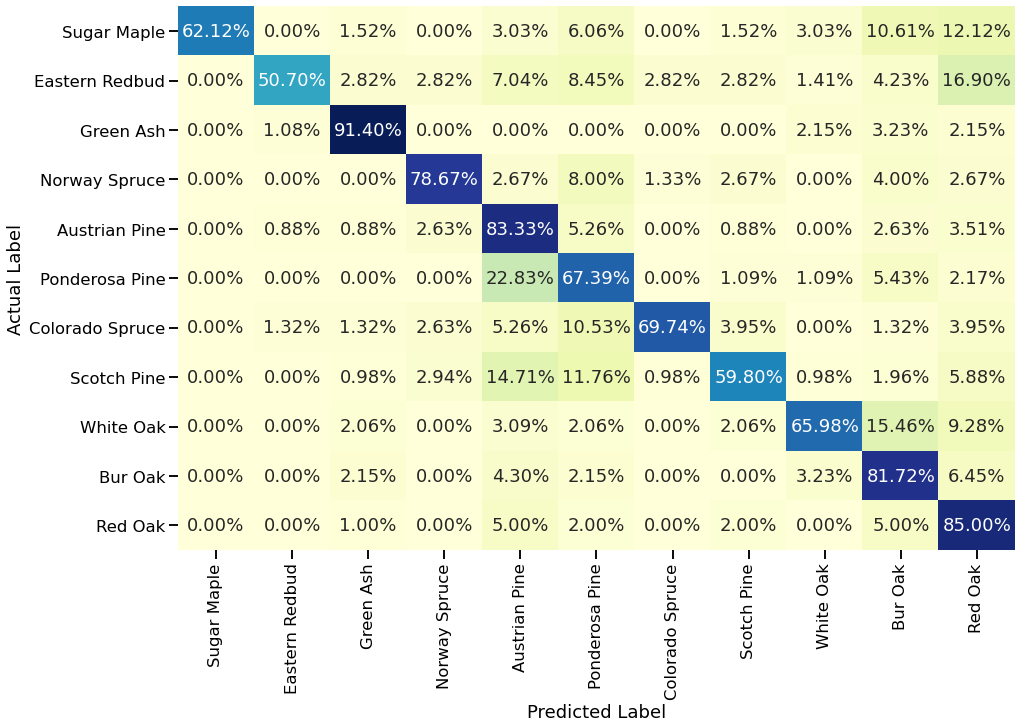

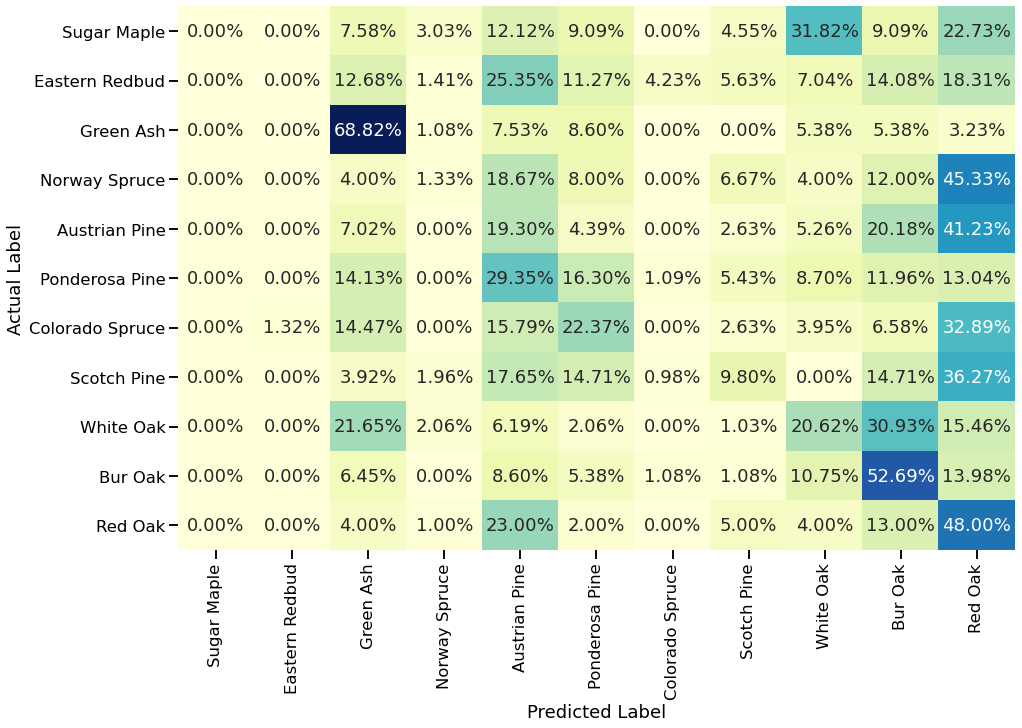

In [21]:
#No dimension reduction
evals = []
model_name = 'canopy_hyper_merged_nd'
model = glob.glob('../pixels/models/*merged_nd.joblib')[0]
print(model)
cp_merge_nd = joblib.load(model)
preds = cp_merge_nd.predict(x_test)
generate_cf(model_name,y_test,preds,nclasses, labels)
#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
merge_nd_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(merge_nd_results)

#Dimesion reduction with PCA
model_name = 'canopy_hyper_merged_pc'
model = glob.glob('../pixels/models/*merged_pc.joblib')[0]
print(model)
merged_pc = joblib.load(model)
df_merged_pc = calculate_pcs(df, x_test,30)
preds = merged_pc.predict(df_merged_pc[df_merged_pc.columns[:-1]])
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
pc30_merged_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(pc30_merged_results)

In [22]:
#compile results 
df_results = pd.concat(evals)
df_results

,Model,Test Accuracy(%)
0,canopy_hyper_merged_nd,73.237998
0,canopy_hyper_merged_pc,23.391216


In [23]:
df_results.to_csv('canopy_hyper_merged_summary_results.csv')